## German-English Translator: Using Seq2seq modelling with Attention Mechanism

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

pd.set_option('display.max_colwidth', 200)

## Loading Data:

In [2]:
def load_data(filepath):
    ifile = open(filepath, mode='rt', encoding='utf-8')
    data = ifile.read()
    ifile.close()
    
    data = data.split('\n')
    data = [ i.split('\t') for i in data ]
    data = [ [i[0],i[1]] for i in data ]
    
    return data

In [3]:
eng_germ = load_data('./datasets/german-eng-translation.txt')
eng_germ = pd.DataFrame(eng_germ, columns=['english','german'])

eng_germ = eng_germ.iloc[:50000]

## Text Cleaning and Preprocessing:

In [8]:
import unicodedata
import re

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(line):
    line = unicode_to_ascii(line.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    line = re.sub(r"[^a-zA-Z?.!,¿]+", " ",line)

    # The strip() method removes any leading (spaces at the beginning) and trailing (spaces at the end) 
    # characters (space is the default leading character to remove)
    line = line.strip()

    return line

Text(0.5, 1.0, 'Max sentence length (German): 18')

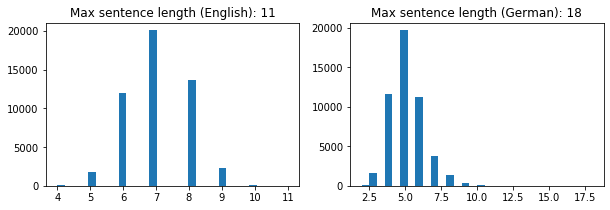

In [9]:
# Convert text to lowercase
eng_germ['english'] = eng_germ['english'].apply(lambda x: preprocess_sentence(x))
eng_germ['german'] = eng_germ['german'].apply(lambda x: preprocess_sentence(x))

# Adding '<start>' and '<end>' tokens to target variable (English)
eng_germ['english'] = eng_germ['english'].apply(lambda x: ('<BOS> ' + x + ' <EOS>'))

# Visualising sentence lengths
len_eng = eng_germ['english'].apply(lambda x: len(x.split()))
len_germ = eng_germ['german'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
_ = plt.hist(len_eng, bins = 30)
plt.title('Max sentence length (English): ' + str(max(len_eng)))
plt.subplot(1,2,2)
_ = plt.hist(len_germ, bins = 30)
plt.title('Max sentence length (German): ' + str(max(len_germ)))

## Tokenizing and Padding :

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [11]:
def tokenize(data):
    tokenizer = Tokenizer(lower = False, split=' ')
    tokenizer.fit_on_texts(data)
    
    tokenized_data = tokenizer.texts_to_sequences(data)
    word_index = tokenizer.word_index
    
    return tokenized_data, word_index

In [12]:
# Tokenization
eng_data, eng_word_index = tokenize(eng_germ['english'])
germ_data, germ_word_index = tokenize(eng_germ['german'])

eng_word_index = {i: word for word, i in eng_word_index.items()}
germ_word_index = {i: word for word, i in germ_word_index.items()}

# (+1) is for padding - '0'
eng_vocab_size = len(eng_word_index) + 1
germ_vocab_size = len(germ_word_index) + 1

print('English Vocabulary size:',eng_vocab_size)
print('German Vocabulary size:',germ_vocab_size)

English Vocabulary size: 6135
German Vocabulary size: 10105


In [13]:
# Padding
eng_max_len = max(len_eng)
germ_max_len = max(len_germ)

# We use post pading because the model needs to know where (timestamp = 1) the sentece starts
x = pad_sequences(germ_data, maxlen=germ_max_len, padding='post')
y = pad_sequences(eng_data, maxlen=eng_max_len, padding='post')

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [15]:
# Function which converts numbers back to words
def convert_int2word(data):
    
    text = []
    for line in data:
        sentence = ' '.join([eng_word_index.get(i) for i in line if eng_word_index.get(i) is not None])
        
        sentence = ' '.join([i for i in sentence.split() if i != 'BOS'])
        sentence = ' '.join([i for i in sentence.split() if i != 'EOS'])
        
        text.append(sentence)

    return text

# .................................................................................................................................
# 1. Simple Model without Attention Mechanism:
- Without Teacher Forcing method - The final hidden state of the encoder part is given as input to each cell of the decoder part (Using RepeatVector).
- What is Teacher Forcing? - [(link)](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/)


## 1.1. Training the model (without Teacher Forcing):

In [18]:
# Used to reload python modules to apply new changes...
from importlib import reload
from models_seq2seq import simple_nmt_model
reload(simple_nmt_model)

from tensorflow.python.keras.callbacks import ModelCheckpoint
from models_seq2seq.simple_nmt_model import SimpleNMTModel

# Compiling the model
model = SimpleNMTModel(germ_vocab_size, eng_vocab_size, germ_max_len, eng_max_len, 512, teacher_forcing = False)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

filepath = './model weigths/SimpleNMTModel_weights1.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
model.summary() # Try to understand the summary by calculating "No. of Params" on your own.

epochs = 20
batch_size=512

# Training the model
history = model.fit(x = x_train, y = y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
                    epochs=epochs, batch_size=batch_size, validation_split = 0.3,
                    callbacks=[checkpoint],
                    verbose=1)
print('\nSaved model weights to location: ' + filepath + ' successfully!')

# Predictions
preds = model.predict(x_test)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 15, 512)      5325312     encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 512), (None, 2099200     embedding_7[0][0]                
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 9, 512)       0           encoder_lstm[0][0]               
____________________________________________________________________________________________

## 1.2. Training the model (with Teacher Forcing):

### Sparse_categorical_crossentropy vs categorical_crossentropy: Loss functions in keras
- If you use 'categorical_crossentropy' you use one hot encoding, and if you use 'sparse_categorical_crossentropy' you encode as normal integers (index of the particular one-hot value, i.e. the position of the '1' in the one-hot encoded vector). In our case we can use either (don't forget to modify the output appropriately)
- But if this is a multi-label classification (i.e. one input may belong to more than one class), then you can only use categorical_crossentropy

In [19]:
# Used to reload python modules to apply new changes...
from importlib import reload
from models_seq2seq import simple_nmt_model
reload(simple_nmt_model)

from tensorflow.python.keras.callbacks import ModelCheckpoint
from models_seq2seq.simple_nmt_model import SimpleNMTModel

# Compiling the model
model = SimpleNMTModel(germ_vocab_size, eng_vocab_size, germ_max_len, eng_max_len - 1, 512, teacher_forcing = True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

filepath = './model weigths/SimpleNMTModel_weights2.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
model.summary() # Try to understand the summary by calculating "No. of Params" on your own.

epochs = 20
batch_size=512

# Assigning appropriate inputs and outputs
training_encoder_input = x_train
training_decoder_input = y_train[:,:-1]
training_decoder_output = y_train[:,1:]

history = model.fit(x = [training_encoder_input, training_decoder_input], y = [training_decoder_output],
                    epochs=epochs, batch_size=batch_size, validation_split = 0.3,
                    callbacks=[checkpoint],
                    verbose=1)
print('\nSaved model weights to location: ' + filepath + ' successfully!')

# Predictions
test_encoder_input = x_test
test_decoder_input = y_test[:,:-1]
test_decoder_output = y_test[:,1:]

preds = model.predict([test_encoder_input, test_decoder_input])

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 15)]         0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 15, 512)      5325312     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 8, 512)       3241984     decoder_input[0][0]              
____________________________________________________________________________________________

# .................................................................................................................................
# 3. Model using Luong's Attention Mechanism:

### Sparse_categorical_crossentropy vs categorical_crossentropy: Loss functions in keras
- If you use 'categorical_crossentropy' you use one hot encoding, and if you use 'sparse_categorical_crossentropy' you encode as normal integers (index of the particular one-hot value, i.e. the position of the '1' in the one-hot encoded vector). In our case we can use either (don't forget to modify the output appropriately)
- But if this is a multi-label classification (i.e. one input may belong to more than one class), then you can only use categorical_crossentropy

In [21]:
# Used to reload python modules to apply new changes...
from importlib import reload
from models_seq2seq import attention
reload(attention)

from tensorflow.python.keras.callbacks import ModelCheckpoint
from models_seq2seq.attention import AttentionModel


# Compilation - subtract '1' from eng_max_len coz only <BOS> (for decoder_input) or <EOS> (for decoder_output) is considered 
model = AttentionModel(germ_vocab_size, eng_vocab_size, germ_max_len, eng_max_len - 1, 512)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

filepath = './model weigths/AttentionModel_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
model.summary()

epochs = 20
batch_size=512

# Assigning appropriate inputs and outputs
training_encoder_input = x_train
training_decoder_input = y_train[:,:-1]
training_decoder_output = y_train[:,1:]

# Training the model
history = model.fit(x=[training_encoder_input, training_decoder_input], 
                    y=[training_decoder_output],
                    epochs=epochs, batch_size=batch_size, validation_split = 0.3,
                    callbacks=[checkpoint],
                    verbose=1)

print('\nSaved model weights to location: ' + filepath + ' successfully!')

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 15)]         0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 15, 300)      3120300     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 8, 300)       1899600     decoder_input[0][0]              
____________________________________________________________________________________________

# .................................................................................................................................
# 4. Attention: WTF method

### 4.1. Training Model:

In [23]:
from tensorflow.python.keras.layers import Dense, LSTM, Embedding, Attention, AdditiveAttention, Concatenate, TimeDistributed, Dot, Activation
from tensorflow.keras import Model, Input

input_vocab_size = germ_vocab_size
output_vocab_size = eng_vocab_size
input_maxwords = germ_max_len
output_maxwords = eng_max_len - 1
hidden_units = 512

embedding_size = 300
    
# Encoder input Embedding...
encoder_input = Input(shape = (None,), name = 'encoder_input') 
encoder_embed_layer = Embedding(input_vocab_size, embedding_size, input_length=input_maxwords, mask_zero=True)
encoder_embed_input = encoder_embed_layer(encoder_input)

# Encoder part... 
encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name='encoder_lstm')
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embed_input)
encoder_state = [encoder_state_h, encoder_state_c]
    
# Decoder input Embedding - Teacher Forcing inputs instead of previous timestep's inputs...
decoder_input = Input(shape = (None,), name = 'decoder_input') 
decoder_embed_layer = Embedding(output_vocab_size, embedding_size, input_length=output_maxwords, mask_zero=True)
decoder_embed_input = decoder_embed_layer(decoder_input)

# Decoder part... 
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_output, _ , _ = decoder_lstm(decoder_embed_input, initial_state=encoder_state)
    

# Attention Layer...Luong's Attention Mechanism...
attention_value_e = Dot(axes=[2, 2], name='attention_score_e')([decoder_output, encoder_output])  # using 'Dot product' -----> (1 of 3 available methods mentioned in Luong's paper)
attention_weights = Activation('softmax', name='attention_vector')(attention_value_e)
context_vector = Dot(axes=[2,1], name='context_vector')([attention_weights, encoder_output])    
    
# attention_layer = AdditiveAttention(name='attention_layer')
# context_vector = attention_layer([decoder_output, encoder_output])

concat_layer = Concatenate(axis=-1)
decoder_combined_context = concat_layer([context_vector, decoder_output])


time_dist_layer = TimeDistributed(Dense(hidden_units, activation="tanh"))
output = time_dist_layer(decoder_combined_context)
    
dense_layer = Dense(output_vocab_size, activation='softmax', name='output_dense_layer')
decoder_pred = dense_layer(output)

# Initializing Model...
model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_pred])


In [24]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

epochs = 40
batch_size=512

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

# Assigning appropriate inputs and outputs
training_encoder_input = x_train
training_decoder_input = y_train[:,:-1]
training_decoder_output = y_train[:,1:]

filepath = './model weigths/AttentionModel_weights_WTF_40epochs.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
model.summary()

# Training the model
history = model.fit(x=[training_encoder_input, training_decoder_input], 
                    y=[training_decoder_output],
                    epochs=epochs, batch_size=batch_size, validation_split = 0.3,
                    callbacks=[checkpoint],
                    verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, None, 300)    3031500     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, None, 300)    1840500     decoder_input[0][0]              
____________________________________________________________________________________________

### 4.2. Test Model:

In [25]:
# Encoder during test time...
encoder_model = Model(inputs = encoder_input, outputs = [encoder_output, encoder_state])

# Decoder during test time
decoder_embed_input_test = decoder_embed_layer(decoder_input)

decoder_state_input_h = Input(shape=(None,)) # Note: shape - doesn't include no of training data
decoder_state_input_c = Input(shape=(None,))
decoder_input_state = [decoder_state_input_h, decoder_state_input_c]

decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embed_input_test, initial_state=decoder_input_state)
decoder_output_state = [decoder_state_h, decoder_state_c]

decoder_model = Model(inputs = [decoder_input] + decoder_input_state, 
                     outputs = [decoder_output] + decoder_output_state)

In [26]:
# Attention during test time

att_decoder_output = Input(shape=(None,hidden_units))
att_encoder_output = Input(shape=(None,hidden_units))   

attention_value_e = Dot(axes=[2, 2], name='attention_score_e')([att_decoder_output, att_encoder_output])
attention_weights = Activation('softmax', name='attention_vector')(attention_value_e)
context_vector = Dot(axes=[2,1], name='context_vector')([attention_weights, att_encoder_output])    

# context_vector = attention_layer([att_decoder_output, att_encoder_output])

decoder_combined_context = concat_layer([context_vector, att_decoder_output])

output = time_dist_layer(decoder_combined_context)    

decoder_prediction = dense_layer(output)

attention_model = Model(inputs = [att_decoder_output, att_encoder_output],
                       outputs = [decoder_prediction, attention_weights])

### 4.3. Decode the sequence:

In [40]:
# decode sequence function here....
def decode_sequence(input_seq):
    
    input_len = len(input_seq)
    
    encoder_output, encoder_state_h, encoder_state_c = encoder_model.predict(input_seq)
    encoder_states = [encoder_state_h, encoder_state_c]
    
    target_seq = np.ones((input_len,1)) # index corresponding to BOS

    decoded_sentence = [''] * input_len
    attention_wts = []
    max_len = eng_max_len - 1
    attention_wts = np.array([])
    
    count = max_len
    while count > 0:
        
        decoder_output, h, c = decoder_model.predict([target_seq] + encoder_states)
                
        output, attention_weights = attention_model.predict([decoder_output, encoder_output])        
        attention_wts = np.hstack([attention_wts, attention_weights]) if attention_wts.size else attention_weights
        sampled_token_index = np.argmax(output, axis = 2)

        for i in range(input_len):
            predicted_word = eng_word_index.get(sampled_token_index[i][0])
            if predicted_word is not None:
                decoded_sentence[i] += predicted_word + ' '
                
        target_seq = sampled_token_index
        states_value = [h,c]
        
        count = count - 1
        
    return decoded_sentence, attention_wts


### 4.4. Test prediction:

In [41]:
test_encoder_input = x_test[:10]
test_decoder_input = y_test[:,:-1][:10]
test_decoder_output = y_test[:,1:][:10]

decoded_sentence,attention_weights = decode_sequence(test_encoder_input)

(10, 1) (10, 1)
(10, 1) (10, 1)
(10, 1) (10, 1)
(10, 1) (10, 1)
(10, 1) (10, 1)
(10, 1) (10, 1)
(10, 1) (10, 1)
(10, 1) (10, 1)
(10, 1) (10, 1)
(10, 1) (10, 1)


In [38]:
attention_weights.shape

(10, 10, 18)

In [31]:
def germ_convert_int2word(data):
        text = []
        for line in data:
            sentence = ' '.join([germ_word_index.get(i) if germ_word_index.get(i) is not None else '<NONE>' for i in line])
            # sentence = ' '.join([i for i in sentence.split() if i != 'EOS'])
            text.append(sentence)
        return text
    
index = 5
print('German:',germ_convert_int2word(test_encoder_input)[index])
print('Actual:',convert_int2word(test_decoder_output)[index])
print('Predicted:',decoded_sentence[index])

German: wer hat die apfel gestohlen <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE>
Actual: who stole the apples
Predicted: who who who who who who who who who who 


In [32]:
attention_weights[index][5]

array([0.0000000e+00, 1.1665504e-33, 2.7060440e-21, 7.5876080e-14,
       7.1428575e-02, 7.1428575e-02, 7.1428575e-02, 7.1428575e-02,
       7.1428575e-02, 7.1428575e-02, 7.1428575e-02, 7.1428575e-02,
       7.1428575e-02, 7.1428575e-02, 7.1428575e-02, 7.1428575e-02,
       7.1428575e-02, 7.1428575e-02], dtype=float32)

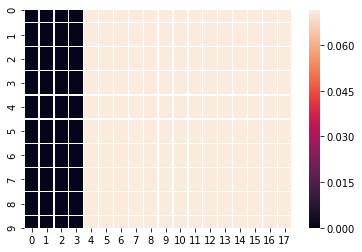

In [33]:
import seaborn as sns
sns.heatmap((attention_weights[index]), linewidths = 0.25)

In [34]:
convert_int2word(test_decoder_output)[:10]

['get away',
 'tom drives a truck',
 'can i pay later',
 'money cant buy life',
 'tom wont be missed',
 'tom is a very shy boy',
 'i have to feed my cat',
 'tom is very busy now',
 'they were shocked',
 'they said its ok']

# .................................................................................................................................
## Loading already saved weights:

In [67]:
from models_seq2seq.attention import AttentionModel
new_model = AttentionModel(germ_vocab_size, eng_vocab_size, germ_max_len, eng_max_len - 1, 512)

# load weights
new_model.load_weights('./model weigths/AttentionModel_weights.hdf5')

# Compile model (required to make predictions)
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
print("Created model and loaded weights from file")

test_encoder_input = x_test
test_decoder_input = y_test[:,:-1]
test_decoder_output = y_test[:,1:]

# Predictions
predictions = new_model.predict(x = [test_encoder_input, test_decoder_input])

# Evaluation scores - like accuracy, loss, etc...
scores = new_model.evaluate(x = [test_encoder_input, test_decoder_input], y = test_decoder_output, verbose=0)
print("Evaluation - " + "%s: %.2f" % (new_model.metrics_names, scores))

Created model and loaded weights from file
Evaluation - ['loss']: 1.30


## Prediction:

In [72]:
test_encoder_input = x_test
test_decoder_input = y_test[:,:-1]
test_decoder_output = y_test[:,1:]

predictions = new_model.predict([test_encoder_input, test_decoder_input])

## Visualising Attention Weigths:

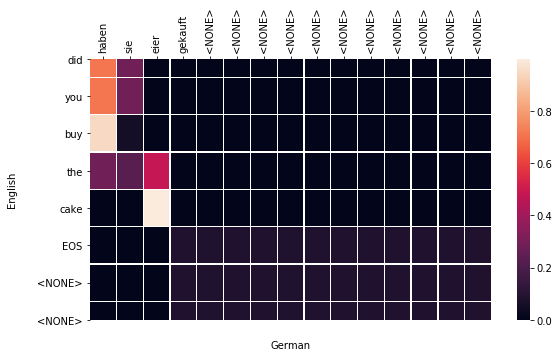

In [152]:
from importlib import reload
from utils import visualize_attention
reload(visualize_attention)
from utils.visualize_attention import DisplayAttentionWeights
from tensorflow.keras import Model

# Extracting Attention weights from the model
display_attention_weights_model = Model(inputs=new_model.input, 
                                        outputs=[new_model.get_layer('attention_vector').output])
attention_weights = display_attention_weights_model.predict([test_encoder_input, test_decoder_input])

# Display
DisplayAttentionWeights(attention_weights,
                        germ_word_index, eng_word_index,
                        actual = test_encoder_input, predicted = np.argmax(predictions, axis = 2),
                        index = 16335, scale = 0.6)

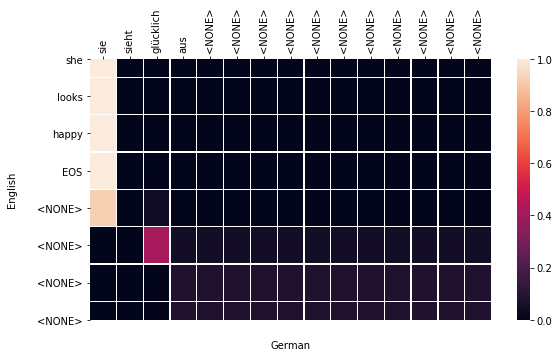

In [151]:
from importlib import reload
from utils import visualize_attention
reload(visualize_attention)
from utils.visualize_attention import DisplayAttentionWeights
from tensorflow.keras import Model

# Extracting Attention weights from the model
display_attention_weights_model = Model(inputs=new_model.input, 
                                        outputs=[new_model.get_layer('attention_vector').output])
attention_weights = display_attention_weights_model.predict([test_encoder_input, test_decoder_input])

# Display
DisplayAttentionWeights(attention_weights,
                        germ_word_index, eng_word_index,
                        actual = test_encoder_input, predicted = np.argmax(predictions, axis = 2),
                        index = 7574, scale = 0.6)

In [136]:
pred_df.iloc[16206]

actual       tom wore a tuxedo
predicted      tom wore a boat
Name: 16206, dtype: object

In [137]:
actual = convert_int2word(test_decoder_output)
predicted = convert_int2word(np.argmax(predictions, axis = 2))

pred_df = pd.DataFrame({'actual' : actual,
                        'predicted' : predicted})
pred_df.sample(10)

,actual,predicted
7706,was his story true,was his last true
14691,it rained heavily,the is off
12594,she kicked the door,the is the door
8719,we have to stop,we have to stop
7565,my sister got engaged,my wife is stolen
8732,hows the apple,how the gate
7574,she looks happy,she looks happy
1886,they were not pleased,they didnt not fired
1353,he pushed me gently,he ran at
15460,i accept your terms,i like you own


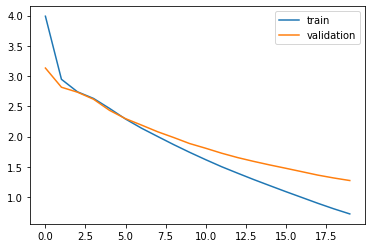

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [26]:
from nltk.translate.bleu_score import corpus_bleu

actual = convert_int2word(y_test)
# actual = [line.split() for line in actual]
predicted = convert_int2word(np.argmax(preds, axis = 2))
# predicted = [line.split() for line in predicted]

# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.524960
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


## Miscellaneous: Ideas to try out to get an improved Accuracy !!
This section lists some ideas that you may wish to explore.

- <b>Data Cleaning: </b> Different data cleaning operations could be performed on the data, such as not removing punctuation or normalizing case, or perhaps removing duplicate English phrases.
- <b>Vocabulary: </b> The vocabulary could be refined, perhaps removing words used less than 5 or 10 times in the dataset and replaced with “unk“.
- <b>More Data: </b> The dataset used to fit the model could be expanded to 50,000, 100,000 phrases, or more.
- <b>Input Order: </b> The order of input phrases could be reversed, which has been reported to lift skill, or a Bidirectional input layer could be used.
- <b>Layers: </b> The encoder and/or the decoder models could be expanded with additional layers and trained for more epochs, providing more representational capacity for the model.
- <b>Units: </b> The number of memory units in the encoder and decoder could be increased, providing more representational capacity for the model.
- <b>Regularization: </b> The model could use regularization, such as weight or activation regularization, or the use of dropout on the LSTM layers.
- <b>Pre-Trained Word Vectors: </b> Pre-trained word vectors could be used in the model.
- <b>Recursive Model: </b> A recursive formulation of the model could be used where the next word in the output sequence could be conditional on the input sequence and the output sequence generated so far (this is a method other than Teacher Forcing).

<b>Hyperparameter tuning, Attention, etc.:</b> [How to Configure an Encoder-Decoder Model for Neural Machine Translation](https://machinelearningmastery.com/configure-encoder-decoder-model-neural-machine-translation/)

In [ ]:
# when [a] + b vs [a,b]

# The differentiation is that it considers all the hidden states of both the encoder LSTM and decoder LSTM to calculate a 
# “variable-length context vector ct, whereas Bahdanau et al. used the previous hidden state of the unidirectional decoder LSTM
# and all the hidden states of the encoder LSTM to calculate the context vector.

# what does masking mean (Attention)?

# Bleu score and attention weights visualisation - check if you got correct output !!!!!!!!!!!!!!!!!!!!!!!
# use the output of previous layer as input to decoder - maybe if you do this your model perfomance may decrease drastically
# and it somehow relates to the weirdness if the attention weights

# Transformers ??????? - has better results and faster (if u have gpu)
# BERT
# use BRNN
# Tensorboard usage.....

# setting random state - same weight initialisation everytime - model training?

In [ ]:
# decrease embedding and no of hidden units to 256 maybe...